## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, I used programmatic tools to understand the results of an A/B test run by an e-commerce website, helping the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [61]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

In [62]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [66]:
print('The number of rows is {}.'.format(df.shape[0]))

The number of rows is 294478.


In [68]:
print('The number of unique users is {}.'.format(df['user_id'].nunique()))

The number of unique users is 290584.


In [70]:
print('The proportion of users converted regardless of the group they are in is {}.'.format(df.converted.mean()))

The proportion of users converted regardless of the group they are in is 0.11965919355605512.


In [75]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

The number of times the `new_page` and `treatment` don't line up.

In [7]:
df.query('group == "treatment" and landing_page == "old_page"').count()['user_id'] + df.query('group == "control" and landing_page == "new_page"').count()['user_id']

3893

In [76]:
# Drop all the unaligned rows
index = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index
df2 = df.drop(index=index)

In [77]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [78]:
df2['user_id'].nunique()

290584

In [79]:
df2['user_id'].shape[0]

290585

The row information for the repeat **user_id**

In [80]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**.

In [81]:
df2.drop_duplicates(subset='user_id', inplace=True)

The probability of an individual converting regardless of the page they receive.

In [82]:
conversion = df2.converted.mean()
conversion

0.11959708724499628

Given that an individual was in the `control` group, the probability they converted is:

In [84]:
control = df2.query('group == "control"')['converted'].mean()
control

0.1203863045004612

Given that an individual was in the `treatment` group, the probability they converted is:

In [85]:
treatment = df2.query('group == "treatment"')['converted'].mean()
treatment

0.11880806551510564

In [86]:
diff = treatment-control
diff

-0.0015782389853555567

The probability that an individual received the new page.

In [87]:
df2.query('landing_page == "new_page"').count()[0]/df2.shape[0]

0.5000619442226688

**From the dataset, the probability of conversion of treatment group is lower than control group. But we need additional statistical evidence to compare the conversion rate of new page with old page.**

<a id='ab_test'></a>
### Part II - A/B Test

The null and alternative hypothesis is:

**$$H_0: p_{new} - p_{old} \leq 0$$**
**$$H_l: p_{new} - p_{old} > 0$$**

The **convert rate** for $p_{new}$ under the null.

In [88]:
p_new=conversion
p_new

0.11959708724499628

The **convert rate** for $p_{old}$ under the null.

In [89]:
p_old=conversion
p_old

0.11959708724499628

What is $n_{new}$?

In [90]:
n_new=df2.query('landing_page == "new_page"').count()[0]
n_new

145310

What is $n_{old}$?

In [91]:
n_old=df2.query('landing_page == "old_page"').count()[0]
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [92]:
boots_new = df2.sample(n_new, replace=True)
new_page_converted=boots_new.converted

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [93]:
boots_old = df2.sample(n_old, replace=True)
old_page_converted=boots_old.converted

Find $p_{new}$ - $p_{old}$

In [94]:
new_page_converted.mean()-old_page_converted.mean()

0.0016014928681626628

Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same processabove. Store all 10,000 values in a numpy array called **p_diffs**.

In [33]:
p_diffs = []
for i in range(10000):
    boots_new = df2.sample(n_new, replace=True)
    boots_old = df2.sample(n_old, replace=True)
    new_page_converted=boots_new.converted
    old_page_converted=boots_old.converted
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**. 

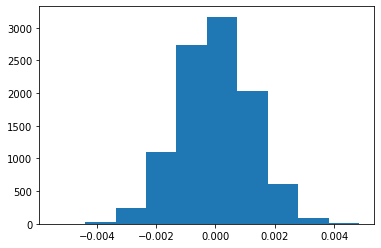

In [95]:
plt.hist(p_diffs);

The proportion of the **p_diffs** which is greater than the actual difference observed in **ab_data.csv**.

In [96]:
(p_diffs > diff).mean()

0.904

**This value is called p-value, which means the probability of observing the evidence in favor of the alternative (new page is better than old page, $p_{new} - p_{old} > 0$), given the null (new page is not better than old page, $ p_{new} - p_{old} \leq 0$) is true. Here, we got the p value 0.904, indicating the lack of evidence to reject the null hypothesis.**

l. We could also use a built-in to achieve similar results.

In [97]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"').count()[0]
n_new = df2.query('landing_page == "new_page"').count()[0]

In [98]:
count = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])
stat, pval = sm.stats.proportions_ztest(count, nobs, value=0)
stat, pval

(1.3109241984234394, 0.18988337448195103)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score is the number of standard deviations of the difference in conversion rate calculated from sample away from zero. The p-value means the probability of observing data in favor of better new pages, given that old pages are better. They agree with the previous results.**

<a id='regression'></a>
### Part III - A regression approach


**Logistic regression.**

In [99]:
df2['intercept']=1
df2[['ab_page', 'page']] = pd.get_dummies(df2['landing_page'])
df2.drop(columns = 'page', inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [100]:
mod=sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
reg=mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [101]:
reg.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-11-04 14:24 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**Here, the p-value is 0.1899. It is different from the value found in the hypothesis test (0.904). The regression model studies the behavior of individuals affected by page views, while the hypothese test focuses on conversion rate, which is a population parameter. In the regression model, the null hypothesis is that the new and old page views don't affect each user's choice on conversion. In the hypothesis test, the null hypothesis is that the conversion rate of new page is not higher than that of old page.**

**The p-value associated with ab_page is higher than 0.05, suggesting page view doesn't contribute to the conversion of an individual. We need to find other factors underlying the conversion decision. However, adding additional terms might bring colinearity among explanatory variables, reducing the accuracy of the model.**

Then check whether the country of users influence the conversion.

In [102]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [103]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [104]:
country = pd.get_dummies(df_new.country)
df_new = df_new.join(country)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [105]:
mod=sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])
reg=mod.fit()
reg.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2020-11-04 14:25 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

**All the p-values are larger than 0.05, suggesting the lack of evidence to reject the null hypothesis, which is page view and country don't affect conversion.**

Then take a look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

In [106]:
df_new['UK_page'] = df_new['ab_page']*df_new['UK']
df_new['US_page'] = df_new['ab_page']*df_new['US']

In [107]:
mod=sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US', 'UK_page', 'US_page']])
reg=mod.fit()
reg.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2020-11-04 14:25 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK_page        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_page        0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

**Based on the results, there is no statistical evidence supporting any of these variables could predict whether or not a individual convert.**

<a id='conclusions'></a>
## Conclusions

In this project, I used traditional hypothesis testing, built-in function in statsmodel, and regression models to analyze the result of this A/B test run by the ecommence website. Based on the results derived from three methods, there is no statistical evidence supporting that page view, country, and their interaction affect the conversion of users.